In [1]:
# Standard Imports
import pandas as pd
import numpy as np

# Plotting Imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid')

# Geospatial Imports
import geopandas as gpd
from keplergl import KeplerGl

_________
**Reading in Accident Data**
__________

In [3]:
# Read in Dataframe with All the accident data
acc_df = pd.read_csv('../data/US_Accidents_Dec20.csv')
len(acc_df.head(1))

1

In [5]:
# lower and eliminate spaces in column names
acc_df.columns = acc_df.columns.str.lower().str.replace(' ', '_')

In [6]:
# dropping unneccessary columns or columns with lots of nulls
acc_df.drop(columns = ['id','source','end_lat','end_lng',
                       'description','number','street',
                       'country','timezone','weather_timestamp', 
                       'airport_code', 'zipcode', 'tmc'], inplace = True)

In [7]:
acc_df.columns

Index(['severity', 'start_time', 'end_time', 'start_lat', 'start_lng',
       'distance(mi)', 'side', 'city', 'county', 'state', 'temperature(f)',
       'wind_chill(f)', 'humidity(%)', 'pressure(in)', 'visibility(mi)',
       'wind_direction', 'wind_speed(mph)', 'precipitation(in)',
       'weather_condition', 'amenity', 'bump', 'crossing', 'give_way',
       'junction', 'no_exit', 'railway', 'roundabout', 'station', 'stop',
       'traffic_calming', 'traffic_signal', 'turning_loop', 'sunrise_sunset',
       'civil_twilight', 'nautical_twilight', 'astronomical_twilight'],
      dtype='object')

# State Data DF Creation

__________________
**Reading in Population Density Data**
_______________

In [69]:
pop_dense_cnty = pd.read_csv('../data/pop_density_county.csv', index_col=0)

In [70]:
# lower and eliminate spaces in column names
pop_dense_cnty.columns = pop_dense_cnty.columns.str.lower().str.replace(' ', '_')

In [71]:
pop_dense_cnty.head(1)

,county_name,density_mi
Rank,,
1,New York,"69,468"


_________
**Read in License Data**, Format into DF, Prepare for Concatenation
________

In [72]:
# Read in Dataframe with data on driver's licensing in each state
license_df = pd.read_csv('../data/licensed_drivers_by_state.csv')

In [73]:
license_df.head(1)

,STATE,UNDER,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,OVER,total_drivers
0,Alabama,"219,648","327,163","347,679","320,583","307,331","292,967","311,675","309,970","339,239","327,915","286,986","242,004","168,934","113,483","110,574","4,026,151"


In [74]:
# lower and eliminate spaces in column names for license_df
license_df.columns = license_df.columns.str.lower().str.replace(' ', '_')

In [75]:
# eliminating commas from total drivers column
license_df['total_drivers'] = license_df['total_drivers'].str.replace(',', '')
# converting total_drivers column to integer type
license_df['total_drivers'] = license_df['total_drivers'].astype(int)

In [76]:
# creating df with only state column and total drivers columns
license_df = license_df.loc[:, ['state', 'total_drivers']]

In [77]:
license_df['state'] = license_df['state'].str.lower()

In [78]:
# replacing dist of col. with district of columbia so I can concatenate with other dfs
license_df['state'].replace('dist. of col. ', 'district of columbia', inplace = True)

In [79]:
# setting the state to index and dropping alaska and hawaii since they're not in accident data
license_df.set_index('state', inplace = True)
license_df.drop(['alaska', 'hawaii'], inplace = True)

In [80]:
license_df.shape

(49, 1)

In [81]:
# sorting index alphabetically and ensuring proper format
license_df.sort_index(inplace = True)
license_df.index = license_df.index.str.lower().str.strip()

______
**Read in Shape Files**, Format into DF and Prepare for Concatenation
______

In [174]:
national_shape = gpd.read_file('../data1/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

In [83]:
# Dropping island territories
national_shape.drop([13, 27, 37, 38, 42, 44, 45], inplace = True)

In [84]:
# lower and eliminate spaces in column names
national_shape.columns = national_shape.columns.str.lower().str.replace(' ', '_')

In [85]:
# converting state name column to lowercase
national_shape['name'] = national_shape['name'].str.lower()

In [86]:
national_shape.shape

(49, 10)

In [87]:
# Setting index to name of state to prepare for concatenation
national_shape.set_index(keys = 'name', inplace = True)

In [88]:
# Sorting index alphabetically and ensuring proper format
national_shape.sort_index(inplace = True)
national_shape.index = national_shape.index.str.lower().str.strip()

________
**Create State Accident Counts**, Form into DF and Prepare for Concatenation
________

In [89]:
# Grouping acc_df by state and getting count of all accidents by state
# using severity column to get counts but I will change it to a column called counts later. 
state_count = acc_df.groupby('state').count()[['severity']]
state_count.head(1)

,severity
state,
AL,56989


In [90]:
# resetting index to numeric so I can map full state names to abbreviated names
state_count = state_count.reset_index()

In [91]:
state_count.index

RangeIndex(start=0, stop=49, step=1)

In [92]:
state_remap = {'AL': 'alabama', 'AR': 'arkansas', 'AZ': 'arizona', 'CA': 'california', 'CO': 'colorado',
 'CT': 'connecticut', 'DC': 'district of columbia', 'DE': 'delaware', 'FL': 'florida',
 'GA': 'georgia', 'IA': 'iowa', 'ID': 'idaho', 'IL': 'illinois',
 'IN': 'indiana', 'KS': 'kansas', 'KY': 'kentucky', 'LA': 'louisiana',
 'MA': 'massachusetts', 'MD': 'maryland', 'ME': 'maine', 'MI': 'michigan',
 'MN': 'minnesota', 'MO': 'missouri', 'MS': 'mississippi', 'MT': 'montana',
 'NC': 'north carolina', 'ND': 'north dakota', 'NE': 'nebraska',
 'NH': 'new hampshire', 'NJ': 'new jersey', 'NM': 'new mexico', 'NV': 'nevada',
 'NY': 'new york', 'OH': 'ohio', 'OK': 'oklahoma', 'OR': 'oregon',
 'PA': 'pennsylvania', 'RI': 'rhode island', 'SC': 'south carolina',
 'SD': 'south dakota', 'TN': 'tennessee', 'TX': 'texas', 'UT': 'utah',
 'VA': 'virginia', 'VT': 'vermont', 'WA': 'washington',
 'WI': 'wisconsin', 'WV': 'west virginia', 'WY':  'wyoming'}

In [93]:
# mapping full names to abbreviated state names
state_count['state'] = state_count['state'].map(state_remap)

In [94]:
# renaming id column to count.
state_count.rename(columns = {'severity': 'count', }, inplace = True)

In [95]:
state_count.head(1)

,state,count
0,alabama,56989


In [96]:
# resetting index to state so that it can be concatenated with license data
state_count.set_index(keys = 'state', inplace = True)

In [97]:
# sorting index alphabetically and ensuring proper format
state_count.sort_index(inplace = True)
state_count.index = state_count.index.str.lower().str.strip()

In [98]:
state_count.shape

(49, 1)

**Read in State Lat and Long**

In [99]:
state_latlong = pd.read_csv('../data/central_lat_long_usstates.csv', index_col = 'State')
state_latlong = state_latlong.sort_values('State')
state_latlong.head(1)

,lat,long
State,,
alabama,32.31823,-86.902298


______
**Concatenating Grouped DF's**
_______

In [100]:
# combining state_count, national_shape and license_df into one df. 
state_df = pd.concat([state_count, national_shape, license_df, state_latlong], axis = 1, verify_integrity = True)
state_df.shape

(49, 13)

In [101]:
state_df.columns

Index(['count', 'statefp', 'statens', 'affgeoid', 'geoid', 'stusps', 'lsad',
       'aland', 'awater', 'geometry', 'total_drivers', 'lat', 'long'],
      dtype='object')

In [102]:
state_df.shape

(49, 13)

In [103]:
state_df['acc_per_cap'] = state_df['count'] / state_df['total_drivers']

In [104]:
state_df

,count,statefp,statens,affgeoid,geoid,stusps,lsad,aland,awater,geometry,total_drivers,lat,long,acc_per_cap
alabama,56989,01,01779775,0400000US01,01,AL,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",4026151,32.318230,-86.902298,0.014155
arizona,93038,04,01779777,0400000US04,04,AZ,00,294198551143,1027337603,"POLYGON ((-114.81629 32.50804, -114.81432 32.5...",5369210,34.048927,-111.093735,0.017328
arkansas,5089,05,00068085,0400000US05,05,AR,00,134768872727,2962859592,"POLYGON ((-94.61783 36.49941, -94.61765 36.499...",2153929,34.799999,-92.199997,0.002363
california,971856,06,01779778,0400000US06,06,CA,00,403503931312,20463871877,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",27213650,36.778259,-119.417931,0.035712
colorado,54028,08,01779779,0400000US08,08,CO,00,268422891711,1181621593,"POLYGON ((-109.06025 38.59933, -109.05954 38.7...",4235384,39.113014,-105.358887,0.012756
connecticut,32488,09,01779780,0400000US09,09,CT,00,12542497068,1815617571,"MULTIPOLYGON (((-72.76143 41.24233, -72.75973 ...",2608061,41.599998,-72.699997,0.012457
delaware,6907,10,01779781,0400000US10,10,DE,00,5045925646,1399985648,"MULTIPOLYGON (((-75.56555 39.51485, -75.56174 ...",812529,39.000000,-75.500000,0.008501
district of columbia,6505,11,01702382,0400000US11,11,DC,00,158340391,18687198,"POLYGON ((-77.11976 38.93434, -77.11253 38.940...",535579,38.895100,-77.036400,0.012146
florida,369559,12,00294478,0400000US12,12,FL,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",15560628,27.994402,-81.760254,0.023750
georgia,107071,13,01705317,0400000US13,13,GA,00,149482048342,4422936154,"MULTIPOLYGON (((-81.27939 31.30792, -81.27716 ...",7261266,33.247875,-83.441162,0.014746


_______________
# Kepler.gl Visualizations
_______________

___________
**Convert acc_df to a Geopandas Dataframe**
___________


In [105]:
# dropping rows that I won't be using in the plots
acc_df.drop(columns = ['temperature(f)', 'wind_chill(f)', 'humidity(%)', 'pressure(in)', 'visibility(mi)', 
                       'wind_direction', 'wind_speed(mph)', 'precipitation(in)', 'weather_condition', 
                       'sunrise_sunset', 'civil_twilight', 'nautical_twilight', 'astronomical_twilight'], inplace = True)


In [106]:
# converting acc_df to geopandas df
# gdp is the geopandas imported as gpd
# GeoDataFrame is a function that converts objects to GeoPandas DF's
# Since There is not geometry object (column) we need to use .points_from_xy
# .points_from_xy() function converts latitude and longitude columns to geometry object. 
# geometry object will be used to plot in geospatial data. 

acc_gdf = gpd.GeoDataFrame(
    acc_df, geometry = gpd.points_from_xy(acc_df['start_lat'], acc_df['start_lng']))

__________________
**Splitting Up acc_gdf into smaller portions**
__________________

In [107]:
# Setting up the length of each new split dataframe
# Splitting 10 times so multiplying length of the dataframe by .10
len_new = int(round(len(acc_gdf) * .10, 0))

# Creating 10 new dataframes of 10 percent of total samples in each new dataframe. 
# Now I will use len_new to index the new dataframes
acc_gdf1 = acc_gdf.iloc[0:len_new, :]
acc_gdf2 = acc_gdf.iloc[len_new:(len_new * 2),  :]
acc_gdf3 = acc_gdf.iloc[(len_new * 2):(len_new * 3),  :]
acc_gdf4 = acc_gdf.iloc[(len_new * 3): (len_new * 4), :]
acc_gdf5 = acc_gdf.iloc[(len_new * 4): (len_new * 5), :]
acc_gdf6 = acc_gdf.iloc[(len_new * 5): (len_new * 6), :]
acc_gdf7 = acc_gdf.iloc[(len_new * 6): (len_new * 7), :]
acc_gdf8 = acc_gdf.iloc[(len_new * 7): (len_new * 8), :]
acc_gdf9 = acc_gdf.iloc[(len_new * 8): (len_new * 9), :]
acc_gdf10 = acc_gdf.iloc[(len_new * 9): (len_new * 10), :]

In [108]:
# Saving all of the split dfs to geojson so that I can use keppler on the web.
# acc_gdf1.to_csv('../data/acc_gdf1.csv') 
# acc_gdf2.to_csv('../data/acc_gdf2.csv')
# acc_gdf3.to_csv('../data/acc_gdf3.csv') 
# acc_gdf4.to_csv('../data/acc_gdf4.csv')
# acc_gdf5.to_csv('../data/acc_gdf5.csv') 
# acc_gdf6.to_csv('../data/acc_gdf6.csv')
# acc_gdf7.to_csv('../data/acc_gdf7.csv')
# acc_gdf8.to_csv('../data/acc_gdf8.csv')
# acc_gdf9.to_csv('../data/acc_gdf9.csv')
# acc_gdf10.to_csv('../data/acc_gdf10.csv')

_________
# Visualizations
__________

_____________________________
## Kepler.gl Plot with All Datapoints
Created a basic national map with accident count, licensed drivers and percentage of accidents per capita (derived by dividing accident count by licensed drivers per state). 

# Data Warning!!!
**This plot contains almost 1GB of data and takes awhile to load**

In [109]:
map_acc = KeplerGl(height = 400)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [110]:
# Adding split dataframes to Keppler using add_data() function.
# I had to split the dataframes (see above) into managable data sizes. Luckily keppler allows you to add as many times as necessary. 

map_acc.add_data(data = acc_gdf1, name = 'Accidents')
map_acc.add_data(data = acc_gdf2, name = 'Accidents')
map_acc.add_data(data = acc_gdf3, name = 'Accidents')
map_acc.add_data(data = acc_gdf4, name = 'Accidents')
map_acc.add_data(data = acc_gdf5, name = 'Accidents')
map_acc.add_data(data = acc_gdf6, name = 'Accidents')
map_acc.add_data(data = acc_gdf7, name = 'Accidents')
map_acc.add_data(data = acc_gdf8, name = 'Accidents')
map_acc.add_data(data = acc_gdf9, name = 'Accidents')
map_acc.add_data(data = acc_gdf10, name = 'Accidents')

In [111]:
# display function calls added data and as you add each new layer (above) you will see the data update into this cell.
# The interactive map displays here.
display(map_acc)


KeplerGl(data={'Accidents': {'index': [3806451, 3806452, 3806453, 3806454, 3806455, 3806456, 3806457, 3806458,…

__________
## Keppler plot of just the State Counts and Per Capita Counts
___________

In [112]:
state_gdf = gpd.GeoDataFrame(state_df)

In [113]:
state_gdf = state_gdf.loc[:, ['count', 'geometry', 'total_drivers', 'acc_per_cap', 'stusps', 'lat', 'long']]

In [114]:
# Instantiate KeplerGl
map_1 = KeplerGl(height = 400)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [115]:
# Add data to KeplerGl instance
map_1.add_data(data = state_gdf, name = 'NationalAccidents')

In [116]:
display(map_1)

KeplerGl(data={'NationalAccidents': {'index': ['alabama', 'arizona', 'arkansas', 'california', 'colorado', 'co…

In [68]:
# map_config_per_capita_heatmap
{
  "version": "v1",
  "config": {
    "visState": {
      "filters": [],
      "layers": [
        {
          "id": "ew6bvll",
          "type": "geojson",
          "config": {
            "dataId": "NationalAccidents",
            "label": "NationalAccidents",
            "color": [
              218,
              112,
              191
            ],
            "columns": {
              "geojson": "geometry"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.8,
              "strokeOpacity": 0.8,
              "thickness": 0.5,
              "strokeColor": None,
              "colorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "strokeColorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "radius": 100,
              "sizeRange": [
                0,
                10
              ],
              "radiusRange": [
                0,
                50
              ],
              "heightRange": [
                0,
                500
              ],
              "elevationScale": 5,
              "stroked": True,
              "filled": False,
              "enable3d": False,
              "wireframe": False
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": None,
            "colorScale": "quantile",
            "sizeField": None,
            "sizeScale": "linear",
            "strokeColorField": None,
            "strokeColorScale": "quantile",
            "heightField": None,
            "heightScale": "linear",
            "radiusField": None,
            "radiusScale": "linear"
          }
        },
        {
          "id": "huy3bll",
          "type": "heatmap",
          "config": {
            "dataId": "NationalAccidents",
            "label": "state",
            "color": [
              177,
              231,
              214
            ],
            "columns": {
              "lat": "lat",
              "lng": "long"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.8,
              "colorRange": {
                "name": "Uber Viz Qualitative 4",
                "type": "qualitative",
                "category": "Uber",
                "colors": [
                  "#12939A",
                  "#DDB27C",
                  "#88572C",
                  "#FF991F",
                  "#F15C17",
                  "#223F9A",
                  "#DA70BF",
                  "#125C77",
                  "#4DC19C",
                  "#776E57",
                  "#17B8BE",
                  "#F6D18A",
                  "#B7885E",
                  "#FFCB99",
                  "#F89570",
                  "#829AE3",
                  "#E79FD5",
                  "#1E96BE",
                  "#89DAC1",
                  "#B3AD9E"
                ]
              },
              "radius": 100
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "weightField": {
              "name": "acc_per_cap",
              "type": "real"
            },
            "weightScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "NationalAccidents": [
              {
                "name": "count",
                "format": None
              },
              {
                "name": "total_drivers",
                "format": None
              },
              {
                "name": "acc_per_cap",
                "format": None
              },
              {
                "name": "stusps",
                "format": None
              },
              {
                "name": "long",
                "format": None
              }
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 0,
      "dragRotate": False,
      "latitude": 40.12986674585066,
      "longitude": -111.16986977067305,
      "pitch": 0,
      "zoom": 2.465289163169173,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "muted",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        224.4071295378559,
        224.4071295378559,
        224.4071295378559
      ],
      "mapStyles": {}
    }
  }
}

{'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'ew6bvll',
     'type': 'geojson',
     'config': {'dataId': 'NationalAccidents',
      'label': 'NationalAccidents',
      'color': [218, 112, 191],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 100,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': 

### Geopandas Heatmap of Accident Count by State
https://geopandas.org/gallery/create_geopandas_from_pandas.html

<Figure size 7200x5040 with 0 Axes>

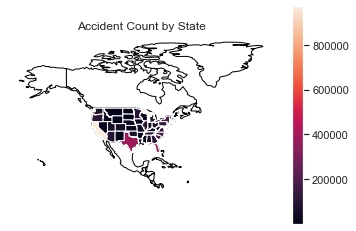

In [123]:
plt.figure(figsize=(100,70))

# reading in Geopandas worldmap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# turn axis off
plt.axis('off')

# plot our ``GeoDataFrame``.
state_gdf.plot(column='count', ax=ax, legend=True);

plt.title('Accident Count by State')

plt.show()

<Figure size 4320x2160 with 0 Axes>

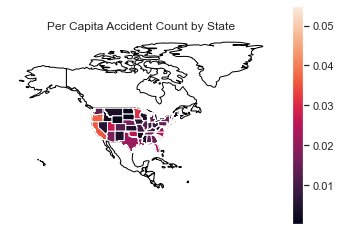

In [125]:
plt.figure(figsize=(60,30))

# reading in Geopandas worldmap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# turn axis off
plt.axis('off')

# plot our ``GeoDataFrame``.
state_gdf.plot(column='acc_per_cap', ax=ax, legend=True)

plt.title('Per Capita Accident Count by State')

plt.show();

________________
# EDA and Visualizations
_______________

____________
# Severity Count by Severity Rating
___________

In [126]:
severity = acc_df.groupby('severity')[['start_lng']].count()
severity.rename(columns = {'start_lng': 'count'}, inplace = True)
severity.reset_index(inplace = True)

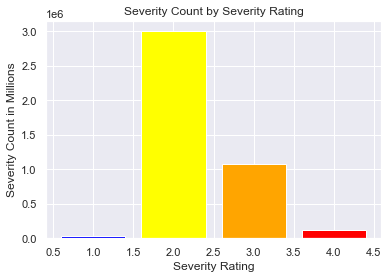

In [127]:
# setting x and height
x = severity['severity']
height = severity['count']

# creating plot
plt.bar(x, height, color = ['blue', 'yellow', 'orange', 'red'])

# setting title and labels
plt.title('Severity Count by Severity Rating')
plt.xlabel('Severity Rating')
plt.ylabel('Severity Count in Millions');

________
## Severity Rating By City
_________

In [128]:
city_acc_count = acc_df.groupby('city')[['severity']].count()
city_acc_count.reset_index(inplace = True)

In [129]:
city_acc_mean = acc_df.groupby('city')[['severity']].mean()
city_acc_mean.head(1)

,severity
city,
Aaronsburg,2.4


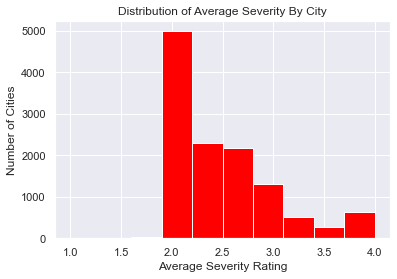

In [130]:
# plot distribution of severity ratings by city
plt.hist(city_acc_mean['severity'], color = ['red'])

# set title and labels
plt.title('Distribution of Average Severity By City')
plt.xlabel('Average Severity Rating')
plt.ylabel('Number of Cities');

______
## Bar Plot Side of Road
______

In [131]:
# creating df with just side of road count
side_df = acc_df.groupby('side')[['severity']].count()
side_df.rename(columns = {'severity': 'count'}, inplace = True)

In [132]:
# dropping unlabeled row with only 2 values. 
side_df.drop(' ', inplace = True)
side_df.reset_index(inplace = True)

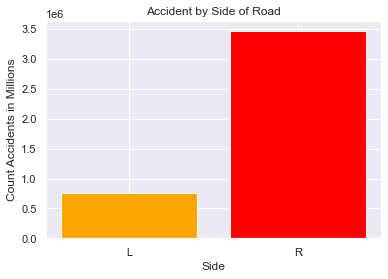

In [133]:
# setting up x and height 
x = list(side_df['side'])
height = side_df['count']

# plotting
plt.bar(x, height = height, color = ['orange', 'red'])

# setting title and labels
plt.title('Accident by Side of Road')
plt.xlabel('Side')
plt.ylabel('Count Accidents in Millions');


_______________
## Bar Plots of Accidents Per State, County and City

___________
## Accidents Per State
____________

In [134]:
# Create a df with accident count and total licensed drivers per state. 
acc_per_state = pd.concat([state_count, license_df], axis = 1)
acc_per_state.head(1)

,count,total_drivers
state,,
alabama,56989,4026151


In [135]:
# creating a accident per capita column
acc_per_state['acc_per_cap'] = acc_per_state['count'] / acc_per_state['total_drivers']
acc_per_state.head(1)

,count,total_drivers,acc_per_cap
state,,,
alabama,56989,4026151,0.014155


In [136]:
# resetting index to numeric index
acc_per_state = acc_per_state.reset_index()

______________
## Plot of Accidents by State
______________

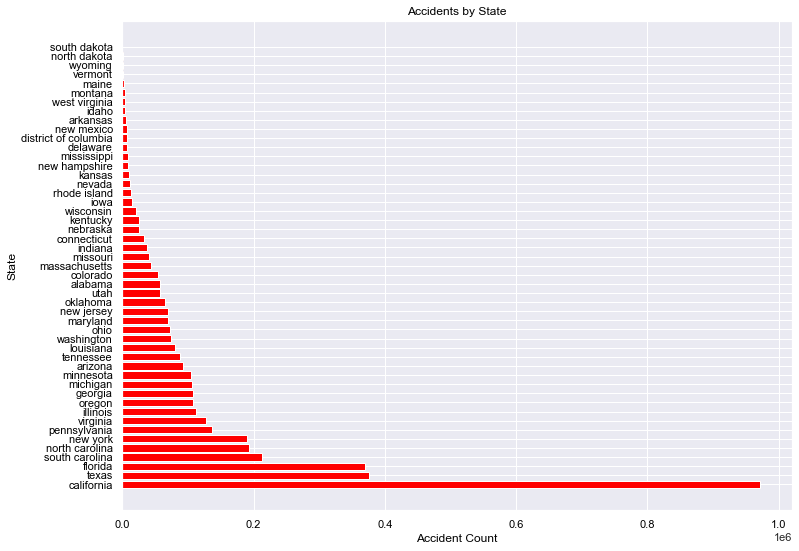

In [137]:
# creating new df of acc_per_state sorted by count
acc_count = acc_per_state.sort_values('count', ascending = False)

# creating variables to house plotting coordinates
x = list(acc_count['count'])
bars = list(acc_count['state'])
y_pos = np.arange(len(bars))

# plotting
plt.figure(figsize = (12,9))
plt.barh(y_pos, x, color = 'red')
plt.yticks(y_pos, bars, color = 'black')
plt.xticks(color = 'black')
plt.xlabel('Accident Count', color = 'black')
plt.ylabel('State', color = 'black')
plt.title('Accidents by State', color = 'black')
plt.show()

**Analysis of Plot of Accidents by State**
__________________

* Not surprisingly California, Texas and Florida rank highest in number of accidents per state. Afterall, they are the three largest states. **What was surprising, however, is North and South Carolina in the top five.** What factors contribute to such a high number of accidents in these two states?

* Looking at the bottom tier of states appears to confirm the relationship between population and number of accidents. Again, this is not surprising. 
____________________

______________
## Plot of Largest Per Capita Accidents Rates By State
_______________________________

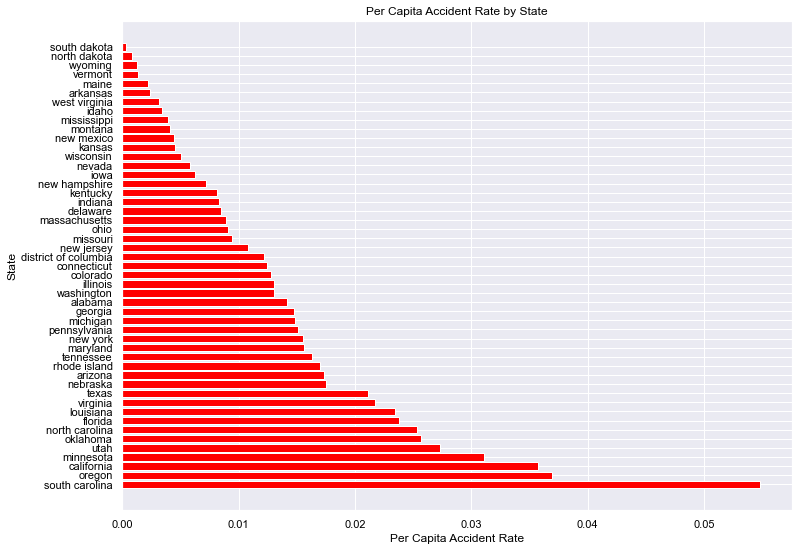

In [138]:
# creating new df of acc_per_state sorted by count
acc_pcapita = acc_per_state.sort_values('acc_per_cap', ascending = False)

# creating variables to house plotting coordinates
x = list(acc_pcapita['acc_per_cap'])
bars = list(acc_pcapita['state'])
y_pos = np.arange(len(bars))

# plotting
plt.figure(figsize = (12,9))
plt.barh(y_pos, x, color = 'red')
plt.yticks(y_pos, bars, color = 'black')
plt.xticks(color = 'black')
plt.xlabel('Per Capita Accident Rate', color = 'black')
plt.ylabel('State', color = 'black')
plt.title('Per Capita Accident Rate by State', color = 'black')
plt.show()

**Analysis of Largest Per Capita Accidents By State Plot**
__________________
* Based on the chart of total number of accidents in each state we would expect to see South Carolina and North Carolina in the top 10. Interestingly, California remains in top 3 on a per-capita basis. In light of this it appears that anecdotal evidence is confirmed by the data to be a relatively challenging state to drive in.

* North Dakot and South Dakota remain at the bottom of the charts when accident totals are adjusted on a per-capita basis. **This highlights a potential relationship between population density and accidents.** 

* Possible exceptions to population density, when considering this on a state level, is Oregon and Utah which are both in top-ten on a per-capita basis and have a diverse population of rural and urban populations. **It may be worth looking into these states further to identify per-capita proportions of accident totals on a rural county or city level.**
_____________________

____________________________
## Plot of Top 25 Accidents Per County
_______________________

In [139]:
# Creating a new df with accidents counts per county
acc_per_county = acc_df.groupby('county')[['severity']].count()
# Renaming severity column to count
acc_per_county.rename(columns = {'severity': 'count'}, inplace = True)
acc_per_county.head(1)

,count
county,
Abbeville,617


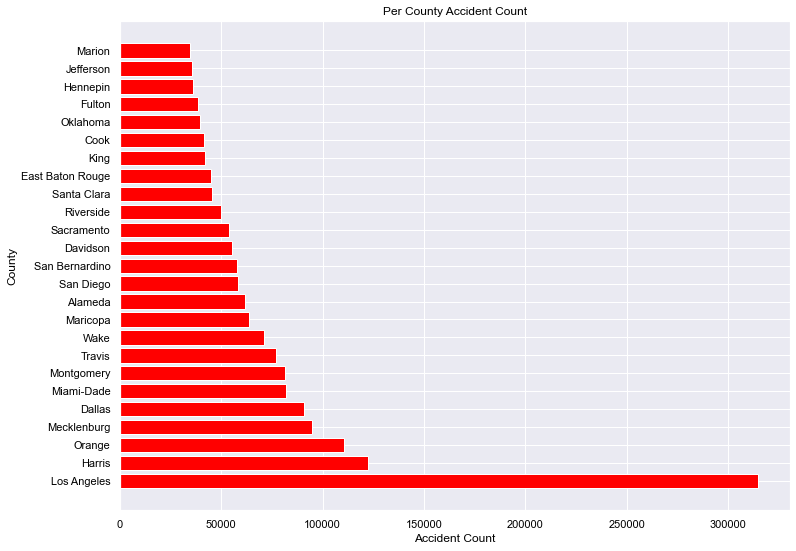

In [140]:
# creating new df of acc_per_county sorted by count
acc_county_count_25 = acc_per_county.nlargest(25, 'count')

# creating variables to house plot coordinates
x = list(acc_county_count_25['count'])
bars = list(acc_county_count_25.index)
y_pos = np.arange(len(bars))

# plot
plt.figure(figsize = (12,9))
plt.barh(y_pos, x, color = 'red')
plt.yticks(y_pos, bars, color = 'black')
plt.xticks(color = 'black')
plt.xlabel('Accident Count', color = 'black')
plt.ylabel('County', color = 'black')
plt.title('Per County Accident Count', color = 'black')
plt.show()

**Analysis of Plot of Accident Count Per County**
* Los Angeles County, is a driver-centric metropolis tops this list almost tripling the accident count of Harris County, Texas. Harris County, the third largest county in the United States is the home of Houston and is a sprawling county growing at a 15% clip annually. These values are to be expected at the top of the chart. 

* I would like to do more analysis on population density and accident rates. If you look at the top counties for accident count Many of them are not in the top 50 of population density. So it almost seems as if at some point population density increases then motor vehicle accidents then decrease. This is likely due to the fact that less people drive and more take mass transit. For instance, Los Angeles County is one of the largest counties by population in the United States but doesn't even break the top 50 counties based on population density. Neither does number two Harris County and number three Orange County ranks 32nd. In fact, Cook County (ranked 19th in population density) is the only county in the list of top 25 of total accident counts that cracks the top 20 via population density. 
* This lack of extreme dense population in the highest accident count counties suggests that larger-by-land-mass, sprawling cities that are more dependent on personal motor vehicles for travel are certainly more risky than densely populated metropolis' that have a good mix of public and private transportation options. However, further research is needed here. 
* This article published on PBS illustrates some of the reason higher-density areas have less crash rates. In a four-year long study at the University of Pennsylvania co-author of the study, Erick Guerra explains that "Fewer roads and slower traffic speeds in Philly explain some of the difference in crash rates. The region’s densest census tracts house 28% of the Delaware Valley’s population, but just 6% of all roadways and far fewer high-speed boulevards or highways. Across the five-county region, roads with average speeds of 45 miles-per-hour witnessed 10 times more deaths on average than roads with 25 miles-per-hour speed limits, the study found."
* Another study found that severity of crashes increases as areas become more rural. This is partly due to people wearing their seatbelts less in rural areas, higher speeds in which people travel in rural areas, increased per capital impaired driving rates and less proximity to trauma centers that can triage severe accidents. There was also some mention of people in rural areas tending to have lower wages and thus driving older cars with outdated or less existent safety features. 


**Sources**

List of most populous counties in the United States
* https://en.wikipedia.org/wiki/List_of_the_most_populous_counties_in_the_United_States

List of most densely populated counties in the United States. 

* https://en.wikipedia.org/wiki/County_statistics_of_the_United_States#Most_densely_populated

City driving often safer than the burbs
* https://whyy.org/articles/study-city-driving-often-safer-than-the-burbs/

Car crash death rates highest in remotest rural areas
* https://www.reuters.com/article/us-health-rural-autos-crash/car-crash-death-rates-highest-in-remotest-rural-areas-idUSKBN1CA2EW



___________
## Plot of Top 25 Accidents Per City
____________

In [141]:
acc_per_city = acc_df.groupby('city')[['severity']].count()
acc_per_city.rename(columns = {'severity': 'count'}, inplace = True)

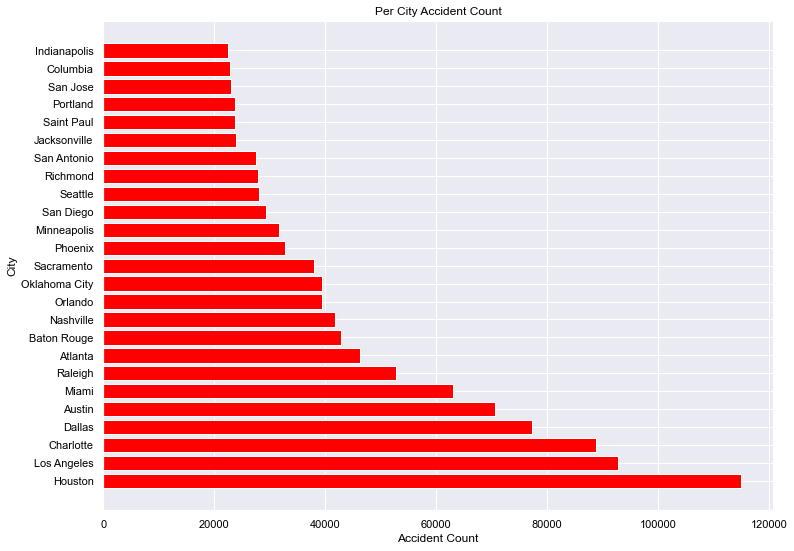

In [142]:
# creating new df of acc_per_city sorted by count
acc_city_count_25 = acc_per_city.nlargest(25, 'count')

# creating variables to house plot coordinates
x = list(acc_city_count_25['count'])
bars = list(acc_city_count_25.index)
y_pos = np.arange(len(bars))

# plot
plt.figure(figsize = (12,9))
plt.barh(y_pos, x, color = 'red')
plt.yticks(y_pos, bars, color = 'black')
plt.xticks(color = 'black')
plt.xlabel('Accident Count', color = 'black')
plt.ylabel('City', color = 'black')
plt.title('Per City Accident Count', color = 'black')
plt.show()

____________
## Plot of Crossing and Severity
A crossing refers to any crossing across roads for pedestrians, cyclists, etc. 

In [143]:
total_crossing = acc_df['crossing'].sum()
perc_crossing = round((total_crossing / len(acc_df) * 100), 2)
print(f"There are {total_crossing} reported crossings in this dataset comprising {perc_crossing}% of the samples.")

There are 347254 reported crossings in this dataset comprising 8.21% of the samples.


In [144]:
acc_df['crossing'] = acc_df['crossing'].map({True: 1, False: 0})

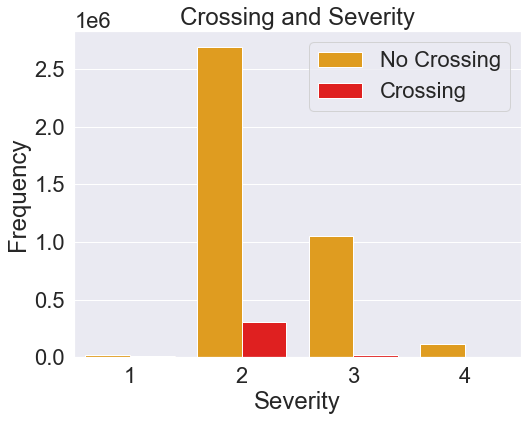

In [145]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2, palette= ['orange', 'red'])
sns.countplot(data = acc_df, x = 'severity', hue = 'crossing')
plt.title('Crossing and Severity')
plt.legend(['No Crossing', 'Crossing'])
plt.ylabel('Frequency')
plt.xlabel('Severity')
plt.show();

**Analysis of Crossing and Severity Plot**
* The vast majority of all accidents that happened at a crossing had a severity of level 2. 
___________________

______
## Plot of Junction and Severity
A junction refers to any highway ramp, exit or entrance. 

In [146]:
total_junction = acc_df['junction'].sum()
perc_junction = round((total_junction / len(acc_df) * 100), 2)
print(f"There are {total_junction} reported junctions in this dataset comprising {perc_junction}% of the samples.")

There are 339366 reported junctions in this dataset comprising 8.02% of the samples.


In [147]:
acc_df['junction'] = acc_df['junction'].map({True: 1, False: 0})

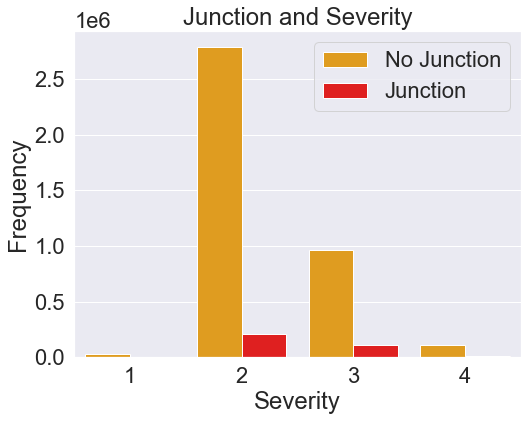

In [148]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2, palette= ['orange', 'red'])
sns.countplot(data = acc_df, x = 'severity', hue = 'junction')
plt.title('Junction and Severity')
plt.legend(['No Junction', 'Junction'])
plt.ylabel('Frequency')
plt.xlabel('Severity')
plt.show();

**Analysis of Junction and Severity**
* Of all the categorical features plotted to this point junction comprises the largest percentage of values accounting for around 8% of the dataset. It appears that the majority of accidents that happen near a highway ramp, exit or entrance have a severity of level 2 and many have a severity of level 3. Very few, if any have level 1 or 4. 

______
## Plot of Station and Severity
Refers to a public transportation station (bus, metro, etc.)

In [149]:
total_station = acc_df['station'].sum()
perc_station = round((total_station / len(acc_df) * 100), 2)
print(f"There are {total_station} reported stations in this dataset comprising {perc_station}% of the samples.")

There are 86099 reported stations in this dataset comprising 2.04% of the samples.


In [150]:
acc_df['station'] = acc_df['station'].map({True: 1, False: 0})

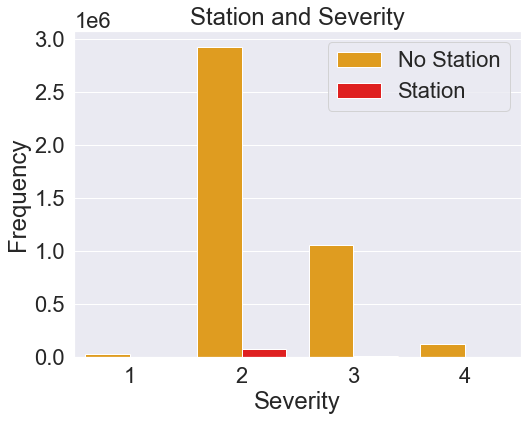

In [151]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2, palette= ['orange', 'red'])
sns.countplot(data = acc_df, x = 'severity', hue = 'station')
plt.title('Station and Severity')
plt.legend(['No Station', 'Station'])
plt.ylabel('Frequency')
plt.xlabel('Severity')
plt.show();

**Analysis of Plot of Station and Severity**
* It appears that mostly all of the accidents that happen near a public transportation station have a severity level of 2. 
________

___________
## Plot of Stop and Severity
Refers to a stop sign at scene of accident. 

In [152]:
total_stop = acc_df['stop'].sum()
perc_stop = round((total_stop / len(acc_df) * 100), 2)
print(f"There are {total_stop} reported stop signs in this dataset comprising {perc_stop}% of the samples.")

There are 72135 reported stop signs in this dataset comprising 1.71% of the samples.


In [153]:
acc_df['stop'] = acc_df['stop'].map({True: 1, False: 0})

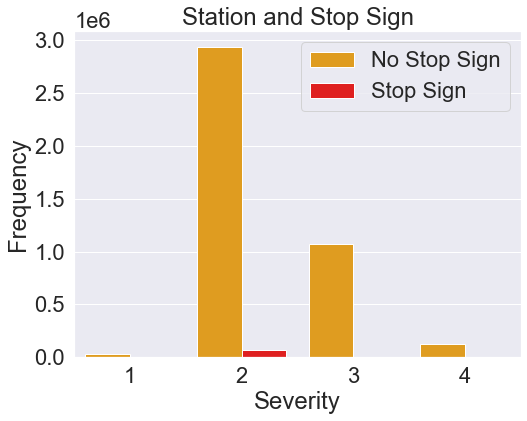

In [154]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2, palette= ['orange', 'red'])
sns.countplot(data = acc_df, x = 'severity', hue = 'stop')
plt.title('Station and Stop Sign')
plt.legend(['No Stop Sign', 'Stop Sign'])
plt.ylabel('Frequency')
plt.xlabel('Severity')
plt.show();

**Analysis of Stop Sign and Severity**
* It appears that nearly all accidents that happen at a stop sign have a severity of level 2. I feel the amount of incidents reported at stop signs seems low. This may have to do with the integrity of the recording process but it may also be right. No way to know for sure at this point. 
________

___________
## Plot of Traffic Signal and Severity
Refers to traffic signal on intersections present at accident site. 

In [155]:
total_signal = acc_df['traffic_signal'].sum()
perc_signal = round((total_signal / len(acc_df) * 100), 2)
print(f"There are {total_signal} reported traffic signals in this dataset comprising {perc_signal}% of the samples.")

There are 727831 reported traffic signals in this dataset comprising 17.21% of the samples.


In [157]:
acc_df['traffic_signal'] = acc_df['traffic_signal'].map({True: 1, False: 0})

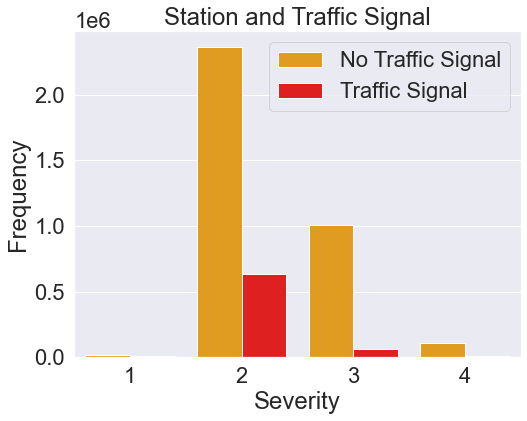

In [158]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2, palette= ['orange', 'red'])
sns.countplot(data = acc_df, x = 'severity', hue = 'traffic_signal')
plt.title('Station and Traffic Signal')
plt.legend(['No Traffic Signal', 'Traffic Signal'])
plt.ylabel('Frequency')
plt.xlabel('Severity')
plt.show();

**Analysis of Plot of Traffic Singal and Severity**

Traffic signal has been the largest of the categorical feature variables analayzed against severity to this point. The presence of a traffic signal may reduce the severity of an accident slightly as you can see the proportion of level 2 and level 3 accidents that do not have a traffic signal seems to be smaller than the proportion of level 2 over level 3 accidents that occur when a traffic signal is present. This signifies a benefit to having traffic signals present at an intersection. 

___________
## Categorical Features that do not offer enough data to analyze


**Give-Way Feature**
Give-way refers to a sign on road which shows priority of passing.  


In [159]:
total_giveway = acc_df['give_way'].sum()
perc_giveway = round((total_giveway / len(acc_df) * 100), 2)
print(f"There are {total_giveway} reported give-ways in this dataset comprising {perc_giveway}% of the samples.")

There are 13186 reported give-ways in this dataset comprising 0.31% of the samples.


**Amenity Feature**
In the context of this data an ammenity refers to a particular place such as restaurant, library, college, bar, etc. where an accident occurred.  

In [161]:
total_amenity = acc_df['amenity'].sum()
perc_amenity = round((total_amenity / len(acc_df) * 100), 2)
print(f"There are {total_amenity} reported amenties in this dataset comprising {perc_amenity}% of the samples.")

There are 49401 reported amenties in this dataset comprising 1.17% of the samples.


**Bump Feature**Refers to speed bump or hump to reduce the speed. 

In [162]:
total_bump = acc_df['bump'].sum()
perc_bump = round((total_bump / len(acc_df) * 100), 2)
print(f"There are {total_bump} reported bumps in this dataset comprising {perc_bump}% of the samples.")

There are 861 reported bumps in this dataset comprising 0.02% of the samples.


**No-exit Feature**
No-exit indicates there is no possibility to travel further by any transport mode along a formal path or route. 

In [163]:
total_noexit = acc_df['no_exit'].sum()
perc_noexit = round((total_noexit / len(acc_df) * 100), 2)
print(f"There are {total_noexit} reported no-exits in this dataset comprising {perc_noexit}% of the samples.")

There are 5967 reported no-exits in this dataset comprising 0.14% of the samples.


**Railway Feature**Indicates the presence of railways near accident. 

In [164]:
total_rail = acc_df['railway'].sum()
perc_rail = round((total_rail / len(acc_df) * 100), 2)
print(f"There are {total_rail} reported railways in this dataset comprising {perc_rail}% of the samples.")

There are 38485 reported railways in this dataset comprising 0.91% of the samples.


**Give-Way Feature**
Give-way is a sign on road which shows priority of passing. 


In [165]:
total_giveway = acc_df['give_way'].sum()
perc_giveway = round((total_giveway / len(acc_df) * 100), 2)
print(f"There are {total_giveway} reported give-ways in this dataset comprising {perc_giveway}% of the samples.")

There are 13186 reported give-ways in this dataset comprising 0.31% of the samples.


**Roundabout Feature**
Refers to a circular road junction.

In [166]:
total_rbout = acc_df['roundabout'].sum()
perc_rbout = round((total_rbout / len(acc_df) * 100), 2)
print(f"There are {total_rbout} reported roundabout in this dataset comprising {perc_rbout}% of the samples.")

There are 237 reported roundabout in this dataset comprising 0.01% of the samples.


**Traffic Calming Feature** Refers to any means for slowing down traffic speed. This is interesting feature since bump is also a feature and bump would fall under this category. Maybe it would efficeint to combine these two features. 

In [167]:
total_calm = acc_df['traffic_calming'].sum()
perc_calm = round((total_calm / len(acc_df) * 100), 2)
print(f"There are {total_calm} reported traffic calming mechanisms in this dataset comprising {perc_calm}% of the samples.")

There are 2121 reported traffic calming mechanisms in this dataset comprising 0.05% of the samples.


**Turning Loop Feature**
Indicates a widened area of a highway with a non-traverable island for turning around. 

In [168]:
total_loop = acc_df['turning_loop'].sum()
perc_loop = round((total_loop / len(acc_df) * 100), 2)
print(f"There are {total_loop} reported turning loops in this dataset comprising {perc_loop}% of the samples.")

There are 0 reported turning loops in this dataset comprising 0.0% of the samples.


____________________

## Start_Time and Severity

In [ ]:
# gdf = gpd.GeoDataFrame(acc_df, 
#                              geometry=gpd.points_from_xy(x=acc_df['start_lng'], y=acc_df['start_lat']))

In [ ]:
# map_2 = KeplerGl(height = 400)

In [ ]:
# # Add data to KeplerGl instance
# map_2.add_data(data = gdf, name = 'Accidents')

In [ ]:
# display(map_2)

____________________
# Kepler.gl Installation and Usage

Kepler.gl is a powerful open source  and interctive geospatial analysis tool for large-scale data sets. It can be used in the web at kepler.gl and also within Jupyter Notebook.

### Using Kepler.gl via web

https://kepler.gl/

### Using Kepler.gl via Jupyter

Using Kepler.gl in Jupyter Notebook Documentation:
https://docs.kepler.gl/docs/keplergl-jupyter

An explanatory Medium article walking through Keppler in Jupyter from installation to visualization:
https://medium.com/vis-gl/introducing-kepler-gl-for-jupyter-f72d41659fbf

**Install Kepler.gl**

`pip install keplergl`

**If using Jupter Lab you also need to install the JupyterLab extension.**

* Jupyter also requires node greater than verion 10.15.0
* With Homebrew installed on Mac you can install node this way. 

`brew install node@10`

**Finally, install Jupyter Lab extension**

`jupyter labextenstion install @jupyter-widgets/jupyterlab-manager keplergl-jupyter`
* Note: We had difficulty getting Keppler to work within Jupyter Lab. After switching to Jupyter Notebook it deployed correctly. 


**Kepler.gl Jupyter Notebook Dependencies**

* Python greater than version 2
* ipywidgets greter than version 7


_______________________

# Geopandas Installation and Usage

GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting. Like it's name suggests, Geopandas is designed to work similarly to the Pandas library but more specifically for Geospatial data. 

**Geopandas User Guide**
https://geopandas.org/

**Geopandas Examples Gallery**
https://geopandas.org/gallery/index.html

**Geopandas Install Documentation:**

https://geopandas.org/install.html

**install Geopandas**

`conda install --channel conda-forge geopandas`

or 

`conda install --channel conda-forge geopandas`

or 

`pip install geopandas`

**See Geopandas install documentation above for more information on each install method and for alternative methods of install directly from Github.**

**GEOPANDAS DEPENDENCIES** Also found in the above Geopandas documentation. 

* numpy
* pandas (version 0.23.4 or later)
* shapely (interface to GEOS)
* fiona (interface to GDAL)
* pyproj (interface to PROJ; version 2.2.0 or later)

**See install link above for further, optional dependencies:**


